## Fake News Detection using Stacked Bi-LSTM

### Importing libraries

In [56]:
# Library imports
import pandas as pd
import numpy as np
import os
import nltk
import spacy
import tensorflow as tf
from tensorflow import keras
from langdetect import detect
from html.parser import HTMLParser
import re
from nltk.stem import WordNetLemmatizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Bidirectional
from keras.utils import to_categorical
import gensim.downloader as api
import gzip
import dill
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

In [57]:
# Setting working directory
os.chdir(r'C:\Users\sanyam.oberoi\OneDrive - Wolters Kluwer\Desktop\Personal\Fake News Detection\fake-news')

### Reading data

In [58]:
# Reading data
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

print(train_df.shape)
print(test_df.shape)

(20800, 5)
(5200, 4)


In [59]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20800 non-null  int64 
 1   title   20242 non-null  object
 2   author  18843 non-null  object
 3   text    20761 non-null  object
 4   label   20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 812.6+ KB


In [60]:
# Finding count of NA values in train data
train_df.isna().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [61]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5200 entries, 0 to 5199
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      5200 non-null   int64 
 1   title   5078 non-null   object
 2   author  4697 non-null   object
 3   text    5193 non-null   object
dtypes: int64(1), object(3)
memory usage: 162.6+ KB


In [62]:
# Finding count of NA values in pred data
test_df.isna().sum()

id          0
title     122
author    503
text        7
dtype: int64

In [64]:
# Checking how the data looks
train_df.sample(10)

,id,title,author,text,label
3867,3867,No Prison Time for White Football Player Accus...,Dylan Gwinn,A white football player from Idaho will not fa...,0
4021,4021,The Middle East Crises Trump Inherits Could St...,Patrick Cockburn,Here's something interesting from The Unz Revi...,1
13687,13687,"Now More Than Ever, We Must Tell the Truth Abo...",NaN,We Must Tell the Truth About the Iraq War Post...,1
10562,10562,"130,000 Americans demand to forbid Soros manip...",NaN,"130,000 Americans demand to forbid Soros manip...",1
7773,7773,The Hodges & Hagmann Hour- America’s Last Chan...,Dave Hodges,\nDoug Hagmann\n \nThe recent show in which Do...,1
20516,20516,‘What if You Weren’t Afraid?’ and 4 More Money...,Ron Lieber,mothers. fathers. Disapproving elders. Par...,0
13260,13260,GLOBAL WARMING ALARMISTS DISAPPOINTED THAT HUR...,Iron Sheik,Home › SCIENCE & TECHNOLOGY › GLOBAL WARMING A...,1
7160,7160,Turkish Government Arrests Opposition Parliame...,NaN,Turkish Government Arrests Opposition Parliame...,1
7736,7736,Exclusive: Opposition Leader: Albania’s Soros-...,Neil W. McCabe,The leader of the opposition in Albania told...,0
7839,7839,Bill Maher Apologizes for Using Racial Slur on...,Daniel Nussbaum,Real Time host Bill Maher has issued an apolog...,0


In [66]:
# Checking if there is class imbalance in data
train_df['label'].value_counts()

1    10413
0    10387
Name: label, dtype: int64

In [68]:
# Making a copy of input data for backup purposes
tr_df = train_df.copy()

# Dropping duplicate records from input train data
tr_df1 = tr_df[['title','author','text','label']].drop_duplicates()
tr_df1.shape

(20691, 4)

In [69]:
# Resetting the index
tr_df1 = tr_df1.reset_index(drop=True)

### Exploratory Data Analysis

In [15]:
# Finding article count corresponding to authors
author_df = tr_df1['author'].value_counts().reset_index(name='Article count')

In [16]:
author_df.shape

(4201, 2)

In [17]:
# Less than half of all the authors have more than 1 news article associated with them
(author_df['Article count'] > 1).sum()

1567

In [18]:
author_df['author word count'] = author_df['index'].apply(lambda x: len(x.split()))

In [19]:
# Wherever # of words in author name > 15, label is '1' -> unreliable (upon looking, these records have data placed under wrong headers)
check_authors = author_df.loc[author_df['author word count'] > 15,'index']

In [20]:
tr_df1.loc[tr_df1['author'].isin(check_authors),'label'].value_counts()

1    31
Name: label, dtype: int64

#### 1) Checking if authors who are associated with multiple news articles are more reliable?

In [21]:
# Checking for authors that have multiple articles associated to them (and have author word count <= 15) -> are more frequent authors more relaible?
multiple_article_authors = author_df.loc[(author_df['Article count'] > 1) & (author_df['author word count'] <= 15),'index']
multiple_article_authors.shape

(1565,)

In [22]:
# Removing 'admin' and 'Anonymous' from the set of multiple_article_authors
multiple_article_authors1 = list(set(multiple_article_authors) - {'admin','Anonymous'})
len(multiple_article_authors1)

1563

In [23]:
# This reflects more frequent authors are more reliable than first time authors (this reliability proportion goes up even more as we increase article count to >= 5)
tr_df1.loc[tr_df1['author'].isin(multiple_article_authors1),'label'].value_counts()

0    8959
1    6928
Name: label, dtype: int64

#### 2) Checking if news articles that have more than 1 author are more reliable?

In [24]:
author_df['No. of authors'] = author_df['index'].apply(lambda x: len(x.split(',')))

In [25]:
multiple_authors = author_df.loc[author_df['No. of authors'] > 1,'index']

In [26]:
# This reflects that reliability proportion shoots up drastically when multiple authors are associated with a news article
tr_df1.loc[tr_df1['author'].isin(multiple_authors),'label'].value_counts()

0    335
1     81
Name: label, dtype: int64

#### 3) Checking if news articles associated with 'admin' and 'Anonymous' authors are less reliable?

In [27]:
# Wherever the 'author' name is either 'admin' or 'Anonymous', article is unreliable
tr_df1.loc[tr_df1['author'].isin(['admin','Anonymous']),'label'].value_counts()

1    232
Name: label, dtype: int64

#### 4) Effect of Title being present/absent on reliability?

In [28]:
# All the articles which have their title missing are unreliable
tr_df1.loc[tr_df1['title'].isna(),'label'].value_counts()

1    518
Name: label, dtype: int64

#### 5) Checking if the Title word count differ across Real and Fake articles?

In [70]:
# Checking word count in title across real and fake articles
tr_df1['title_word_count'] = tr_df1['title'].apply(lambda x: len(str(x).split()))
tr_df1['text_word_count'] = tr_df1['text'].apply(lambda x: len(str(x).split()))

tr_df1.loc[tr_df1['title'].isna(),'title_word_count'] = 0
tr_df1.loc[tr_df1['text'].isna(),'text_word_count'] = 0

In [71]:
%matplotlib inline
import matplotlib.pyplot as plt

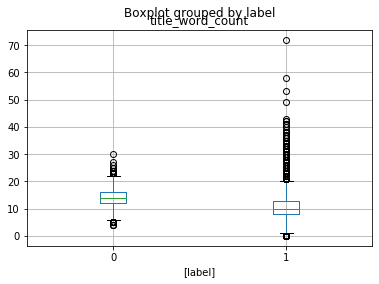

In [72]:
# Interquartile range of title_word_count for reliable articles is higher than that of fake articles (fake articles have lesser title text for quite a high proportion of articles) 
tr_df1[['label','title_word_count']].boxplot(by='label')

In [73]:
tr_df1.groupby('label')[['title_word_count','text_word_count']].describe()

title_word_count                                                    \
                 count       mean       std  min   25%   50%   75%   max   
label                                                                      
0              10387.0  13.665929  2.914845  4.0  12.0  14.0  16.0  30.0   
1              10304.0  10.553863  5.198871  0.0   8.0  10.0  13.0  72.0   

      text_word_count                                                     \
                count        mean         std  min    25%    50%     75%   
label                                                                      
0             10387.0  878.996534  739.375488  1.0  400.0  773.0  1180.5   
1             10304.0  635.994856  969.276963  0.0  171.0  381.0   788.0   

                
           max  
label           
0      14641.0  
1      24234.0

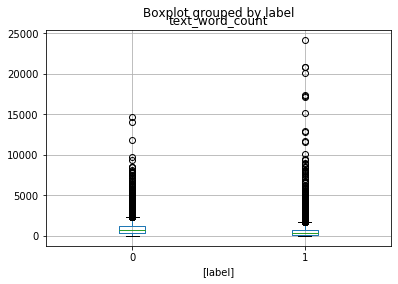

In [74]:
# Interquartile range of text_word_count for reliable articles is higher than that of fake articles (fake articles have lesser text for quite a high proportion of articles) 
tr_df1[['label','text_word_count']].boxplot(by='label')

#### 6) Effect of Text being present/absent on reliability and also checking for presence of languages other than English?

In [75]:
tr_df1['language_text'] = np.where((tr_df1['text'].isna()) | (tr_df1['text'] == ' '),'Empty',detect(str(tr_df1['text'])))

In [76]:
# Wherever the text of article is missing, all such articles are unreliable
tr_df1.loc[tr_df1['language_text'] == 'Empty','label'].value_counts()

1    112
Name: label, dtype: int64

#### 7) Checking for reliability of articles where author name contains '.com'?

In [36]:
# All articles that have '.com' in their author name are unreliable
auth_check = author_df.loc[author_df['index'].str.find('.com') != -1,'index']

tr_df1.loc[tr_df1['author'].isin(auth_check),'label'].value_counts()

1    475
Name: label, dtype: int64

#### 8) Checking if presence of certain Named Entities in news Title makes it more authentic/reliable?

In [77]:
# Loading spacy's English Large model
nlp = spacy.load("en_core_web_lg")

In [78]:
# Function to return all named entities present in a string
def named_entities(txt):
    if (txt is not None) and (txt != ''):
        doc = nlp(str(txt))
        l = []
        for ent in doc.ents:
            l.append(ent.label_)
        return l
    else:
        return []

tr_df1['named_entities'] = tr_df1['title'].apply(lambda x: named_entities(x))

In [79]:
new_lst = []
for x in tr_df1['named_entities']:
    for y in x:
        new_lst.append(y)

In [80]:
from collections import Counter
cntr = Counter(new_lst)

In [81]:
# Creating a column for each unique Named Entity found in training corpus
for i in cntr:
    tr_df1[i] = tr_df1['named_entities'].apply(lambda x: 1 if i in x else 0)

In [94]:
# ORG, PERSON, GPE, NORP, WORK_OF_ART -> presence of these entities in article Title lends reliability to it
tr_df1.groupby('WORK_OF_ART')['label'].value_counts()

WORK_OF_ART  label
0            1        9635
             0        8966
1            0        1421
             1         669
Name: label, dtype: int64

#### 9) Checking if presence/absence of Web URLs in article Text lend reliability to it?

In [82]:
# Creating meta-data variables -> Counting the no. of URLs present in the text of an article (may lend credibility)
url_regex = r"(?i)\b((?:https?:(?:\/{1,3}|[a-z0-9%])|[a-z0-9.\-]+[.](?:com|net|org|edu|gov|mil|aero|asia|biz|cat|coop|info|int|jobs|mobi|museum|name|post|pro|tel|travel|xxx|ac|ad|ae|af|ag|ai|al|am|an|ao|aq|ar|as|at|au|aw|ax|az|ba|bb|bd|be|bf|bg|bh|bi|bj|bm|bn|bo|br|bs|bt|bv|bw|by|bz|ca|cc|cd|cf|cg|ch|ci|ck|cl|cm|cn|co|cr|cs|cu|cv|cx|cy|cz|dd|de|dj|dk|dm|do|dz|ec|ee|eg|eh|er|es|et|eu|fi|fj|fk|fm|fo|fr|ga|gb|gd|ge|gf|gg|gh|gi|gl|gm|gn|gp|gq|gr|gs|gt|gu|gw|gy|hk|hm|hn|hr|ht|hu|id|ie|il|im|in|io|iq|ir|is|it|je|jm|jo|jp|ke|kg|kh|ki|km|kn|kp|kr|kw|ky|kz|la|lb|lc|li|lk|lr|ls|lt|lu|lv|ly|ma|mc|md|me|mg|mh|mk|ml|mm|mn|mo|mp|mq|mr|ms|mt|mu|mv|mw|mx|my|mz|na|nc|ne|nf|ng|ni|nl|no|np|nr|nu|nz|om|pa|pe|pf|pg|ph|pk|pl|pm|pn|pr|ps|pt|pw|py|qa|re|ro|rs|ru|rw|sa|sb|sc|sd|se|sg|sh|si|sj|Ja|sk|sl|sm|sn|so|sr|ss|st|su|sv|sx|sy|sz|tc|td|tf|tg|th|tj|tk|tl|tm|tn|to|tp|tr|tt|tv|tw|tz|ua|ug|uk|us|uy|uz|va|vc|ve|vg|vi|vn|vu|wf|ws|ye|yt|yu|za|zm|zw)\/)(?:[^\s()<>{}\[\]]+|\([^\s()]*?\([^\s()]+\)[^\s()]*?\)|\([^\s]+?\))+(?:\([^\s()]*?\([^\s()]+\)[^\s()]*?\)|\([^\s]+?\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’])|(?:(?<!@)[a-z0-9]+(?:[.\-][a-z0-9]+)*[.](?:com|net|org|edu|gov|mil|aero|asia|biz|cat|coop|info|int|jobs|mobi|museum|name|post|pro|tel|travel|xxx|ac|ad|ae|af|ag|ai|al|am|an|ao|aq|ar|as|at|au|aw|ax|az|ba|bb|bd|be|bf|bg|bh|bi|bj|bm|bn|bo|br|bs|bt|bv|bw|by|bz|ca|cc|cd|cf|cg|ch|ci|ck|cl|cm|cn|co|cr|cs|cu|cv|cx|cy|cz|dd|de|dj|dk|dm|do|dz|ec|ee|eg|eh|er|es|et|eu|fi|fj|fk|fm|fo|fr|ga|gb|gd|ge|gf|gg|gh|gi|gl|gm|gn|gp|gq|gr|gs|gt|gu|gw|gy|hk|hm|hn|hr|ht|hu|id|ie|il|im|in|io|iq|ir|is|it|je|jm|jo|jp|ke|kg|kh|ki|km|kn|kp|kr|kw|ky|kz|la|lb|lc|li|lk|lr|ls|lt|lu|lv|ly|ma|mc|md|me|mg|mh|mk|ml|mm|mn|mo|mp|mq|mr|ms|mt|mu|mv|mw|mx|my|mz|na|nc|ne|nf|ng|ni|nl|no|np|nr|nu|nz|om|pa|pe|pf|pg|ph|pk|pl|pm|pn|pr|ps|pt|pw|py|qa|re|ro|rs|ru|rw|sa|sb|sc|sd|se|sg|sh|si|sj|Ja|sk|sl|sm|sn|so|sr|ss|st|su|sv|sx|sy|sz|tc|td|tf|tg|th|tj|tk|tl|tm|tn|to|tp|tr|tt|tv|tw|tz|ua|ug|uk|us|uy|uz|va|vc|ve|vg|vi|vn|vu|wf|ws|ye|yt|yu|za|zm|zw)\b\/?(?!@)))"

tr_df1['URL_count'] = tr_df1['text'].apply(lambda x: len(re.findall(url_regex,str(x))))

In [45]:
# This suggests whenever there is a URL present in an article Text, it is unreliable (contrary to my initial hypothesis)
tr_df1.loc[tr_df1['URL_count'] > 0,'label'].value_counts()

1    2561
Name: label, dtype: int64

### Data Pre-Processing

In [46]:
html_parser = HTMLParser()

# Creating WordNetLemmatizer object 
lemmatizer = WordNetLemmatizer()

# Function for cleaning data
def clean_text(text):
    text = str(text)
    
    # Stripping leading and trailing whitespaces from text and lowercasing it
    text = text.strip().lower()
    
    # Converting HTML entities
    text = html_parser.unescape(text)
    
    # Removing web URLs from text
    no_url_text = re.sub(url_regex, ' ', text)
    
    # Removing special characters and digits
    alpha_text = re.sub(r'[^a-zA-Z]',' ',no_url_text)
    
    # Removing multiple spaces
    text_cleaned = re.sub(r'\s+', ' ', alpha_text)
    
    return text_cleaned


# Function for normalizing data
def data_normalize(text):
    cleaned_text = clean_text(text)
    return ' '.join([lemmatizer.lemmatize(word) for word in cleaned_text.split()])

In [47]:
# function for tokenizing and padding text sequence
def data_prep(data_list, tokenizer, max_len):
    data = tokenizer.texts_to_sequences(data_list)
    data = pad_sequences(data, padding='post', maxlen=max_len)
    return data

In [95]:
# Model #1 -> baseline using just 'title' and Stacked Bi-Directional LSTM
train_df_mod1 = tr_df1.copy()
test_df_mod1 = test_df.copy()

# Removing empty records from title
train_df_mod1 = train_df_mod1[(train_df_mod1['title'].notna()) & (train_df_mod1['title'] != '')]
train_df_mod1.shape

(20173, 29)

In [96]:
# Normalizing Title of both train/validation and pred data
train_df_mod1['normalized_cleaned_title'] = train_df_mod1['title'].apply(lambda x: data_normalize(x))

test_df_mod1['normalized_cleaned_title'] = test_df_mod1['title'].apply(lambda x: data_normalize(x))

C:\Users\sanyam.oberoi\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  del sys.path[0]


In [97]:
# Checking the distribution of word count in train data 'Title' -> Needed to set the max_seq_length for the model (around 99% records have less than 25 words in their title)
train_df_mod1['title_length'] = train_df_mod1['normalized_cleaned_title'].apply(lambda x: len(x.split()))
test_df_mod1['title_length'] = test_df_mod1['normalized_cleaned_title'].apply(lambda x: len(x.split()))

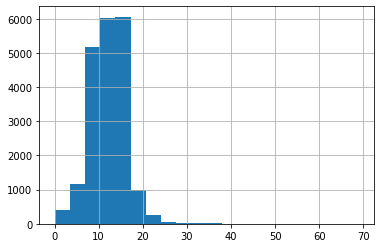

In [98]:
# Plotting word count distribution of train data 'Title'
train_df_mod1['title_length'].hist(bins=20)

### Model Creation

In [48]:
# function for model creation (Stacked Bi-LSTM using Transfer Learning (Google Word2Vec embeddings trained on Google News corpus))
def create_model(vocab_size, embed_dim, max_len, embedding_matrix):
    lstm_out1 = 32
    lstm_out2 = 32

    model = Sequential()
    model.add(Embedding(vocab_size, embed_dim, weights=[embedding_matrix], input_length = max_len, trainable=False, name='embedding_layer')) 
    model.add(Bidirectional(LSTM(lstm_out1, return_sequences=True, dropout=0.5),merge_mode='concat', name='bi_lstm_layer1'))
    model.add(Bidirectional(LSTM(lstm_out2, dropout=0.5), merge_mode='concat', name='bi_lstm_layer2'))
    model.add(Dense(1,activation='sigmoid', name='dense'))
    return model

In [55]:
# Vectorizing text data
max_features = 8000 # Train data has approx 10k unique words
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(train_df_mod1['normalized_cleaned_title'])

# Tokenizing and padding train and test data
X_train = tokenizer.texts_to_sequences(train_df_mod1['normalized_cleaned_title'])
max_len = 25 # basis word count distribution of train data 'Title'
X_train = pad_sequences(X_train, padding='post', maxlen=max_len)

X_test = data_prep(test_df_mod1['normalized_cleaned_title'], tokenizer, max_len)

In [56]:
y_train = np.array(train_df_mod1['label'])

In [157]:
# print(api.load('word2vec-google-news-300', return_path=True))

C:\Users\sanyam.oberoi/gensim-data\word2vec-google-news-300\word2vec-google-news-300.gz


#### Loading and fetching pre-trained word embeddings

In [56]:
# Loading pre-trained Word2Vec embeddings
vocab_size = len(tokenizer.word_index) + 1
embed_dim = 300

model = api.load("word2vec-google-news-300")

In [63]:
# Fetching word embeddings for only words present in vocab
word_vectors = model.wv

embedding_matrix = np.zeros((vocab_size, 300))
for word, index in tokenizer.word_index.items():
    if word in word_vectors.vocab:
        embedding_vector = word_vectors[word]
    else:
        embedding_vector = None
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

C:\Users\sanyam.oberoi\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


In [70]:
# with gzip.open(r'C:\Users\sanyam.oberoi\OneDrive - Wolters Kluwer\Desktop\Personal\Fake News Detection\fake-news\model\embedding_matrix.dill.gz','wb') as f:
#     dill.dump(embedding_matrix,f)

In [83]:
os.chdir(r'C:\Users\sanyam.oberoi\OneDrive - Wolters Kluwer\Desktop\Personal\Fake News Detection\fake-news')

In [88]:
# Storing embedding matrix (for later use) for only the words present in vocab (helps in reducing the size)
with gzip.open(r'model\embedding_matrix.dill.gz','rb') as f:
    embedding_matrix = dill.load(f) 

# Creating the model
model = create_model(vocab_size, embed_dim, max_len, embedding_matrix)
model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_layer (Embedding)  (None, 25, 300)           5639400   
_________________________________________________________________
bi_lstm_layer1 (Bidirectiona (None, 25, 64)            85248     
_________________________________________________________________
bi_lstm_layer2 (Bidirectiona (None, 64)                24832     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 5,749,545
Trainable params: 110,145
Non-trainable params: 5,639,400
_________________________________________________________________
None


### Model Training

In [94]:
# Train and Validation data split
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=0, stratify=y_train)

In [95]:
# Fitting the model
history = model.fit(X_tr, y_tr, batch_size=64, epochs=20, verbose=1, validation_data=(X_val,y_val)) # , class_weight=

Epoch 1/20
253/253 [==============================] - 9s 36ms/step - loss: 0.1562 - accuracy: 0.9400 - val_loss: 0.1035 - val_accuracy: 0.9668
Epoch 2/20
253/253 [==============================] - 9s 37ms/step - loss: 0.1399 - accuracy: 0.9449 - val_loss: 0.1057 - val_accuracy: 0.9651
Epoch 3/20
253/253 [==============================] - 10s 38ms/step - loss: 0.1384 - accuracy: 0.9460 - val_loss: 0.1113 - val_accuracy: 0.9636
Epoch 4/20
253/253 [==============================] - 10s 38ms/step - loss: 0.1350 - accuracy: 0.9466 - val_loss: 0.1241 - val_accuracy: 0.9544
Epoch 5/20
253/253 [==============================] - 11s 42ms/step - loss: 0.1293 - accuracy: 0.9483 - val_loss: 0.1171 - val_accuracy: 0.9571
Epoch 6/20
253/253 [==============================] - 11s 43ms/step - loss: 0.1314 - accuracy: 0.9492 - val_loss: 0.1185 - val_accuracy: 0.9566
Epoch 7/20
253/253 [==============================] - 10s 41ms/step - loss: 0.1254 - accuracy: 0.9495 - val_loss: 0.1184 - val_accuracy: 0

### Model Performance Evaluation

In [105]:
# Model performance on training data
print(classification_report(y_true = y_tr,y_pred = model.predict_classes(X_tr)))
print(confusion_matrix(y_true = y_tr,y_pred = model.predict_classes(X_tr)))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      8309
           1       0.99      0.99      0.99      7829

    accuracy                           0.99     16138
   macro avg       0.99      0.99      0.99     16138
weighted avg       0.99      0.99      0.99     16138

[[8264   45]
 [  77 7752]]


In [103]:
# Model performance on validation data
print(classification_report(y_true = y_val,y_pred = model.predict_classes(X_val)))
print(confusion_matrix(y_true = y_val,y_pred = model.predict_classes(X_val)))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95      2078
           1       0.95      0.95      0.95      1957

    accuracy                           0.95      4035
   macro avg       0.95      0.95      0.95      4035
weighted avg       0.95      0.95      0.95      4035

[[1974  104]
 [ 104 1853]]


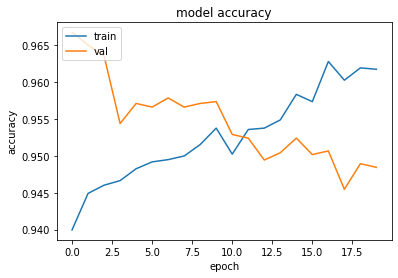

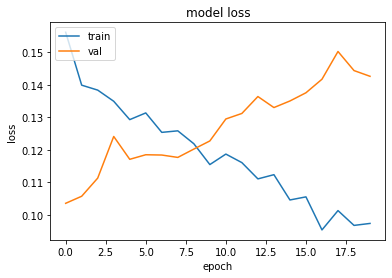

In [106]:
# Plotting the model performance
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

### Persisting the model (for later use)

In [ ]:
# Persisting tokenizer
with open('model/tokenizer_v2.dill','wb') as f:
    dill.dump(tokenizer, f)

# Persisting model 
model.save('model/bi-lstm_v2')